# Test Greykite

### Imports

In [24]:
%matplotlib inline

import pandas as pd
from greykite.algo.changepoint.adalasso.changepoint_detector import ChangepointDetector
from greykite.algo.forecast.silverkite.constants.silverkite_holiday import SilverkiteHoliday
from greykite.algo.forecast.silverkite.constants.silverkite_seasonality import SilverkiteSeasonalityEnum
from greykite.algo.forecast.silverkite.forecast_simple_silverkite_helper import cols_interact
from greykite.common import constants as cst
from greykite.common.features.timeseries_features import build_time_features_df
from greykite.common.features.timeseries_features import convert_date_to_continuous_time
from greykite.framework.benchmark.data_loader_ts import DataLoaderTS
from greykite.framework.templates.autogen.forecast_config import EvaluationPeriodParam
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from greykite.detection.detector.greykite import GreykiteDetector
from greykite.detection.detector.config import ADConfig
from greykite.detection.detector.data import DetectorData
from greykite.common.constants import GrowthColEnum

import plotly
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import psycopg2

import warnings
warnings.filterwarnings('ignore')

## Read dataset from farmago v1 and farmago v2

In [25]:
fg_full_csv = pd.read_csv('./ts_fg.csv')
df = pd.DataFrame(fg_full_csv)
df = df[df['principio_activo'] == 'ACETAMINOFEN']
df = df[df['qty'] > 0]
df['date'] = pd.to_datetime(df['date'])
df

,principio_activo,name,date,qty,price_unit,branch_id
2,ACETAMINOFEN,{'en_US': 'ACETAMINOFEN 650MG X 30 TABLETAS (...,2023-12-29,1.0,95.23,10.0
4,ACETAMINOFEN,{'en_US': 'TACHIPIRIN GOTAS PEDIATRICAS (ACETA...,2023-12-23,1.0,147.81,2.0
5,ACETAMINOFEN,{'en_US': 'ATAEML FORTE (ACETAMINOFEN) 650MG X...,2023-12-24,1.0,120.97,2.0
10,ACETAMINOFEN,{'en_US': 'ACETAMINOFEN 500MG X 20 TABLETAS (...,2023-12-23,1.0,66.93,2.0
11,ACETAMINOFEN,{'en_US': 'ACETAMINOFEN 650MG X 30 TABLETAS (...,2023-12-23,1.0,94.86,19.0
...,...,...,...,...,...,...
92275,ACETAMINOFEN,{'en_US': 'ACETAMINOFEN 500MG X 10 COMPRIMIDOS...,2025-01-04,1.0,42.58,34.0
92276,ACETAMINOFEN,{'en_US': 'ACETAMINOFEN 650MG X 10 COMPRIMIDOS...,2024-12-31,1.0,39.54,48.0
92277,ACETAMINOFEN,{'en_US': 'ANALPER JARABE (ACETAMINOFEN) 150MG...,2024-12-31,1.0,167.01,48.0
92278,ACETAMINOFEN,{'en_US': 'ACETAMINOFEN 650MG X 10 COMPRIMIDOS...,2024-12-31,1.0,39.54,48.0


Hist by branch

<AxesSubplot:ylabel='Frequency'>

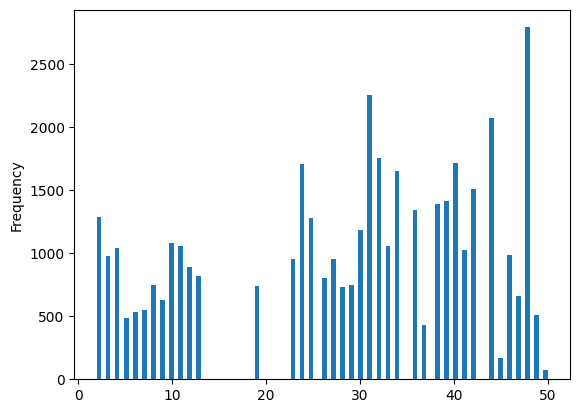

In [26]:
df['branch_id'].plot.hist(bins=100 )

## Load active branchs by days 


In [27]:
active_branches_df = pd.read_csv('./branch_by_day.csv')
active_branches_df = pd.DataFrame(active_branches_df)
active_branches_df['date'] = pd.to_datetime(active_branches_df['date'])
active_branches_df = active_branches_df.rename(columns={'date': 'ts', 'count': 'nro_branches'})

active_branches_df

,ts,nro_branches
0,2023-11-01,10
1,2023-11-02,11
2,2023-11-03,11
3,2023-11-04,10
4,2023-11-05,8
...,...,...
561,2025-05-17,25
562,2025-05-18,23
563,2025-05-19,25
564,2025-05-20,25


## load products by principio activo sold

In [28]:
products_df = pd.read_csv('./products_by_day.csv')
products_df = pd.DataFrame(products_df)
products_df = products_df[products_df['principio_activo'] == 'ACETAMINOFEN']
products_df = products_df.rename(columns={'date': 'ts', 'count': 'nro_products'})
products_df['ts'] = pd.to_datetime(products_df['ts'])
products_df = products_df.drop(columns=['principio_activo'])
products_df

,ts,nro_products
0,2023-11-01,15
2,2023-11-02,13
4,2023-11-03,14
6,2023-11-04,10
8,2023-11-05,9
...,...,...
1122,2025-05-17,16
1124,2025-05-18,14
1126,2025-05-19,16
1128,2025-05-20,17


## Sum sales of each sucursal

In [29]:
df_sum = df.groupby(['date', 'principio_activo'])['qty'].sum().reset_index()
df_sum = df_sum.rename(columns={'date': 'ts', 'qty': 'y'})
df_sum = df_sum[(df_sum['ts'] > '2024-05-01') & (df_sum['ts'] < '2025-05-21')]
df_sum['ts'] = pd.to_datetime(df_sum['ts'])
df_sum.describe()

,y
count,384.000000
mean,108.476562
std,50.666054
min,13.000000
25%,68.000000
50%,101.500000
75%,147.000000
max,315.000000


Hist of qty of sales

<AxesSubplot:ylabel='Frequency'>

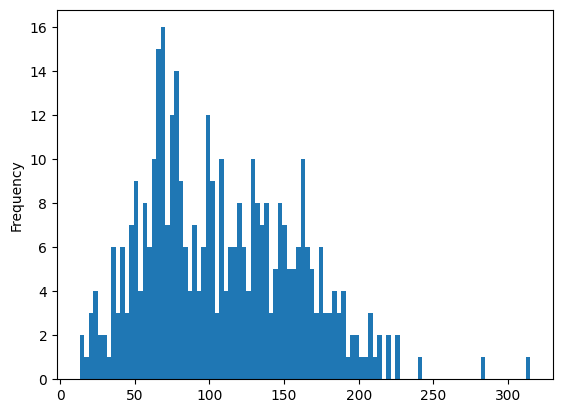

In [30]:
df_sum['y'].plot.hist(bins=100 )


## Load regressors

In [31]:
df_full = pd.merge(df_sum, active_branches_df, on=['ts'], how='left')
df_full = pd.merge(df_full, products_df, on=['ts'], how='left')
df_full

,ts,principio_activo,y,nro_branches,nro_products
0,2024-05-02,ACETAMINOFEN,52.0,16,16
1,2024-05-03,ACETAMINOFEN,61.0,16,16
2,2024-05-04,ACETAMINOFEN,35.0,16,13
3,2024-05-05,ACETAMINOFEN,15.0,14,8
4,2024-05-06,ACETAMINOFEN,39.0,16,14
...,...,...,...,...,...
379,2025-05-16,ACETAMINOFEN,221.0,25,17
380,2025-05-17,ACETAMINOFEN,207.0,25,16
381,2025-05-18,ACETAMINOFEN,96.0,23,14
382,2025-05-19,ACETAMINOFEN,315.0,25,16


<AxesSubplot:>

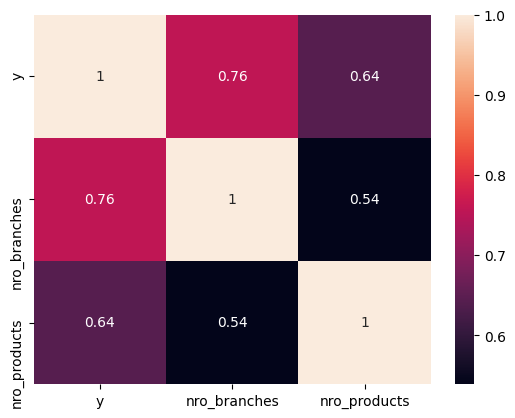

In [32]:
df_full.corr()
sns.heatmap(df_full.corr(), annot=True)

In [51]:
# df_full['nro_branches_lag1'] = df_full['nro_branches'].shift(1)
# df_full['nro_products_lag1'] = df_full['nro_products'].shift(1)
# df_full['nro_branches_lag7'] = df_full['nro_branches'].shift(7)
# df_full['nro_products_lag7'] = df_full['nro_products'].shift(7)
# df_full = df_full.dropna().reset_index(drop=True)
df_full

,ts,principio_activo,y,nro_branches,nro_products
0,2024-05-02,ACETAMINOFEN,52.0,16,16
1,2024-05-03,ACETAMINOFEN,61.0,16,16
2,2024-05-04,ACETAMINOFEN,35.0,16,13
3,2024-05-05,ACETAMINOFEN,15.0,14,8
4,2024-05-06,ACETAMINOFEN,39.0,16,14
...,...,...,...,...,...
379,2025-05-16,ACETAMINOFEN,221.0,25,17
380,2025-05-17,ACETAMINOFEN,207.0,25,16
381,2025-05-18,ACETAMINOFEN,96.0,23,14
382,2025-05-19,ACETAMINOFEN,315.0,25,16


In [34]:
freq = 'D'

ts = UnivariateTimeSeries()
ts.load_data(
    df=df_sum,
    time_col="ts",
    value_col="y",
    freq=freq
    # anomaly_info=anomaly_info,
    # regressor_cols=["sale_price"]
)

ts.plot()

In [35]:
# No es un dataframe pero pareceira un dataframe5
ts = UnivariateTimeSeries()
ts.load_data(
    df=df_sum,
    time_col="ts",
    value_col="y",
    freq=freq
    # anomaly_info=anomaly_info,
    # regressor_cols=["sale_price"]
)

metadata = MetadataParam(
    time_col='ts', # Usa el nombre de tu columna de tiempo
    value_col='y',  # Usa el nombre de tu columna de valor
    freq=freq,       # Frecuencia diaria
    # train_end_date=None, # Greykite lo determinará
    # anomaly_info=None    # Si no tienes etiquetas de anomalías para el entrenamiento
)

# EvaluationPeriodParam (para AD, a menudo se ajusta para no tener un test_horizon largo en el config inicial)
evaluation_period = EvaluationPeriodParam(
    test_horizon=0,       # Para AD, el foco es el ajuste en los datos de entrenamiento
    cv_max_splits=0       # Para AD, el CV se maneja de forma diferente o se simplifica
)

# ModelComponentsParam
model_components = ModelComponentsParam(
    autoregression={
        "autoreg_dict": {
            "lag_dict": {"orders": [1, 7]},
            "agg_lag_dict": {"orders_list": [(1, 7)]}
        }
    },
    events={ # Configuración de eventos/festivos (ajusta a tu país/necesidad)
        "auto_holiday": False,
         "holidays_to_model_separately": "auto",
         "holiday_lookup_countries": "auto",
         "holiday_pre_num_days": 2,
         "holiday_post_num_days": 2,
         "holiday_pre_post_num_dict": None,
         "daily_event_df_dict": None, # Puedes pasar un df con eventos custom aquí
    },
    lagged_regressors={ # Greykite crea los lags para estos regresores
        "lagged_regressor_dict": {
            'nro_branches': { # Nombre de la columna original en tu df_full
                "lag_dict": {"orders": [1, 7]}, # Quiero lag 1 y lag 7 de nro_branches
                # "agg_lag_dict": {"interval_list": [(1,7)]} # Opcional: promedio de lags
            },
            'nro_products': "auto" # Dejar que Greykite elija lags para nro_products
        }
    },
    custom={ # Aquí van los regresores para templates como SILVERKITE_EMPTY
        "min_admissible_value": 0, # Si tus ventas no pueden ser negativas
        "normalize_method": "zero_to_one" # O "mean_std", o None
    }
)

In [36]:
anomaly_detector = GreykiteDetector()  # Creates an instance of the Greykite anomaly detector

# ForecastConfig
forecast_config = ForecastConfig( # Renombrado para evitar confusión si tienes otro forecast_config
    model_template=ModelTemplateEnum.AUTO.name, # El template del tutorial de AD
    metadata_param=metadata,
    # model_components_param=model_components,
    coverage=None,  # Importante para que AD ajuste las bandas de confianza
    # evaluation_period_param=evaluation_period,
    forecast_horizon=1 # Para AD, el horizonte de pronóstico puede ser corto
                       # ya que se enfoca en la bondad de ajuste al histórico.
)

ad_config = ADConfig()  # Default anomaly detection config

detector = GreykiteDetector(
    forecast_config=forecast_config,
    ad_config=ad_config,
    reward=None)

In [37]:
train_data = DetectorData(df=df_full)
train_data
detector.fit(data=train_data)

2025-05-25 00:45:27 Greykite [WARNING]: No anomalies are provided and no outliers have been found. Setting 'anomaly_df' to None.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [38]:
print(detector.fitted_df[detector.fitted_df["is_anomaly_predicted"] == False])

fig = detector.plot(
    phase="train",
    title="Greykite Detector Peyton Manning - fit phase")
plotly.io.show(fig)

            ts  actual    forecast  forecast_lower  forecast_upper  \
18  2024-05-20    69.0   68.493517       67.028847       69.958187   
23  2024-05-25    62.0   62.464359       60.999689       63.929028   
58  2024-06-29    57.0   57.120581       55.655911       58.585250   
77  2024-07-18    92.0   93.134399       91.669730       94.599069   
90  2024-07-31    97.0   96.096653       94.631983       97.561323   
100 2024-08-10    61.0   59.835224       58.370554       61.299894   
112 2024-08-22    81.0   81.086578       79.621908       82.551247   
127 2024-09-06    87.0   88.113699       86.649029       89.578369   
129 2024-09-08    41.0   40.923596       39.458926       42.388266   
137 2024-09-16    90.0   91.327562       89.862893       92.792232   
141 2024-09-20   111.0  109.941825      108.477156      111.406495   
199 2024-11-17   109.0  109.406771      107.942102      110.871441   
227 2024-12-15   124.0  123.285597      121.820928      124.750267   
229 2024-12-17   184

In [39]:

print(detector.summary())

======================= Anomaly Detection Model Summary ========================

Number of observations: 384
Model: GreykiteDetector
Number of detected anomalies: 363

Average Anomaly Duration: 16 days 12:00:00
Minimum Anomaly Duration: 1 days 00:00:00
Maximum Anomaly Duration: 57 days 00:00:00

Alert Rate(%): 94.53125
Optimal Objective Value: 0
Optimal Parameters: {'coverage': 0.05, 'volatility_features': []}

============================ Forecast Model Summary ============================

Number of observations: 384,   Number of features: 120
Method: Ridge regression
Number of nonzero features: 120
Regularization parameter: 16.1

Residuals:
         Min           1Q       Median           3Q          Max
      -112.7       -11.76      -0.6876        12.33        127.9

            Pred_col Estimate Std. Err Pr(>)_boot sig. code              95%CI
           Intercept    25.21    12.33      0.044         *      (2.247, 49.4)
 events_C...New Year   -1.842    1.187      0.088         

<AxesSubplot:ylabel='Frequency'>

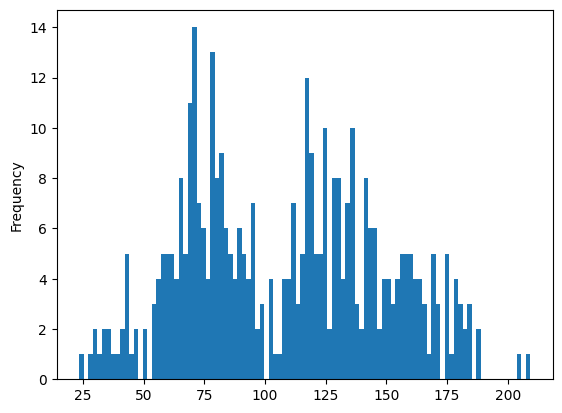

In [40]:
df_fited = detector.fitted_df.rename(columns={"forecast": "y"})

df_fited['y'].plot.hist(bins=100 )

In [41]:
forecaster = Forecaster()

model_components_param_silverkite = ModelComponentsParam(
     seasonality={
         "auto_seasonality": False,
         "yearly_seasonality": "auto",
         "quarterly_seasonality": "auto",
         "monthly_seasonality": "auto",
         "weekly_seasonality": "auto",
         "daily_seasonality": "auto",
     },
     growth={
         "growth_term": GrowthColEnum.linear.name
     },
     events={
         "auto_holiday": False,
         "holidays_to_model_separately": "auto",
         "holiday_lookup_countries": "auto",
         "holiday_pre_num_days": 2,
         "holiday_post_num_days": 2,
         "holiday_pre_post_num_dict": None,
         "daily_event_df_dict": None,
     },
     changepoints={
         "auto_growth": False,
         "changepoints_dict": {
             "method": "auto",
             "yearly_seasonality_order": 15,
             "resample_freq": "3D",
             "regularization_strength": 0.6,
             "actual_changepoint_min_distance": "30D",
             "potential_changepoint_distance": "15D",
             "no_changepoint_distance_from_end": "90D"
         },
         "seasonality_changepoints_dict": None
     },
     autoregression={
         "autoreg_dict": "auto",
         "simulation_num": 10  # simulation is not triggered with ``autoreg_dict="auto"``
     },
     regressors={
         "regressor_cols": []
     },
     lagged_regressors={
         "lagged_regressor_dict": None
     },
     uncertainty={
         "uncertainty_dict": None
     },
     custom={
         "fit_algorithm_dict": {
             "fit_algorithm": "ridge",
             "fit_algorithm_params": None,
         },
         "feature_sets_enabled": "auto",  # "auto" based on data freq and size
         "max_daily_seas_interaction_order": 5,
         "max_weekly_seas_interaction_order": 2,
         "extra_pred_cols": [],
         "drop_pred_cols": None,
         "explicit_pred_cols": None,
         "min_admissible_value": None,
         "max_admissible_value": None,
         "normalize_method": "zero_to_one"
     }
 )


result = forecaster.run_forecast_config(
            df=df_fited,
            config=ForecastConfig(
                model_template=ModelTemplateEnum.SILVERKITE.name,
                forecast_horizon=10, 
                coverage=0.95,
                metadata_param=metadata,
                model_components_param=model_components_param_silverkite,
                # evaluation_period_param=evaluation_period 
            )
        )

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [42]:
result_auto = forecaster.run_forecast_config(
            df=df_fited,
            config=ForecastConfig(
                model_template=ModelTemplateEnum.AUTO.name,
                forecast_horizon=10, 
                coverage=0.95,
                metadata_param=metadata,
                # model_components_param=model_components_param_silverkite,
                # evaluation_period_param=evaluation_period 
            )
        )

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [43]:
result.forecast.plot()

In [44]:
result_auto.forecast.plot()

In [45]:
frecast_wo_2025_df = result.forecast.df_test

frecast_wo_2025_df

frecast_wo_2025_df[frecast_wo_2025_df['ts'] > '2025-05-20']['forecast_lower'].sum()

1602.9853592361428

In [46]:
frecast_wo_2025_df.describe()

,actual,forecast,forecast_lower,forecast_upper
count,0.0,10.000000,10.000000,10.000000
mean,NaN,186.704141,160.298536,213.109746
std,NaN,28.818501,30.784372,27.302311
min,NaN,115.221999,84.709931,145.734067
25%,NaN,187.282048,158.107641,209.753296
50%,NaN,195.307358,172.716947,221.413822
75%,NaN,203.409123,177.347399,229.207432
max,NaN,211.243408,186.757537,236.756981


In [47]:
print(pd.DataFrame(result.backtest.test_evaluation, index=["Value"]).transpose())

                                                         Value
CORR                                                  0.929549
R2                                                     0.77383
MSE                                                 278.942292
RMSE                                                 16.701566
MAE                                                  15.125398
MedAE                                                14.818961
MAPE                                                   9.39347
MedAPE                                                8.094122
sMAPE                                                 4.842826
Q80                                                  10.575186
Q95                                                  12.081429
Q99                                                  12.483094
OutsideTolerance1p                                         1.0
OutsideTolerance2p                                         0.9
OutsideTolerance3p                                     

In [48]:
print(pd.DataFrame(result_auto.backtest.test_evaluation, index=["Value"]).transpose())



                                                         Value
CORR                                                  0.929549
R2                                                     0.77383
MSE                                                 278.942292
RMSE                                                 16.701566
MAE                                                  15.125398
MedAE                                                14.818961
MAPE                                                   9.39347
MedAPE                                                8.094122
sMAPE                                                 4.842826
Q80                                                  10.575186
Q95                                                  12.081429
Q99                                                  12.483094
OutsideTolerance1p                                         1.0
OutsideTolerance2p                                         0.9
OutsideTolerance3p                                     

In [49]:
# retail_csv = pd.read_csv('./data_productos_ventas_3.csv')
# df_real = pd.DataFrame(retail_csv)
# df_real['fecha_venta'] = pd.to_datetime(df_real['fecha_venta'])

# df_real = df_real.query('`codigo_articulo` == 386')
    
# # # df_real = df_real.groupby(['fecha_venta']).agg({'cantidad': 'sum'}).reset_index()
# df_real.rename(columns={'fecha_venta': 'ts', 'cantidad': 'y'}, inplace=True)
# df_real = df_real.groupby(pd.Grouper(key='ts', freq=freq)).agg({'y': 'sum'}).reset_index()


# ts2025 = UnivariateTimeSeries()
# ts2025.load_data(
#     df=df_real,
#     time_col="ts",
#     value_col="y",
#     freq=freq
#     # anomaly_info=anomaly_info,
#     # regressor_cols=["sale_price"]
# )

# ts2025.plot()

In [50]:
# df_real[df_real['ts'] >= '2025-01-01']['y'].describe()
# df_real.describe()